<a href="https://colab.research.google.com/github/jrgrajek/Capstone/blob/main/Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [26]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [27]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [28]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [29]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [30]:
# Create a small batch size for images .... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [31]:
# Define our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example on the next video we'll build out the actual model
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [32]:
# Grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [33]:
X_Train.shape

torch.Size([1, 28, 28])

In [34]:
x = X_Train.view(1,1,28,28)

In [35]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [37]:
# 1 single image, 6 is the filters we asked for, 26x26 (padding not needed)
x.shape

torch.Size([1, 6, 26, 26])

In [39]:
# Pass through the pooling layer
x = F.max_pool2d(x,2,2) # Kernal of 2 and stride of 2

In [41]:
x.shape  # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [42]:
# Do our 2nd Convolutional Layer
x = F.relu(conv2(x))

In [44]:
x.shape # Again, we didn't set padding so we lose 2 pixles around the outside of the image

torch.Size([1, 16, 11, 11])

In [45]:
# Pooling Layer
x = F.max_pool2d(x,2,2)

In [47]:
x.shape # 11/2 = 5.5 but we have to round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [49]:
((28 - 2)/ 2 - 2) / 2

5.5

In [61]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.conv2 = nn.Conv2d(6, 16, 3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2) # 2x2 kernal and stride 2
    # Second Pass
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2) # 2x2 kernal and stride 2

    # Re-view to flaten it out
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)


    return F.log_softmax(x, dim=1)

In [62]:
# Create an instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [63]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the learning Rate, longer it is going to take to train

In [64]:
from multiprocessing.process import current_process
import time
start_time = time.time()

# Create Variables to Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the trining set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions
    batch_corr = (predicted == y_train).sum() # how many we got correct this batch
    trn_corr += batch_corr  # keep track as we go along in training

    # Update our Parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biases with test
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]  # adding up correct predictions
      tst_corr += (predicted == y_test).sum()  # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.10077302157878876
Epoch: 0 Batch: 1200 Loss: 0.06396330893039703
Epoch: 0 Batch: 1800 Loss: 0.01605856977403164
Epoch: 0 Batch: 2400 Loss: 0.07665002346038818
Epoch: 0 Batch: 3000 Loss: 0.4555548131465912
Epoch: 0 Batch: 3600 Loss: 0.09306709468364716
Epoch: 0 Batch: 4200 Loss: 0.10131406784057617
Epoch: 0 Batch: 4800 Loss: 0.0032753068953752518
Epoch: 0 Batch: 5400 Loss: 0.0022645490244030952
Epoch: 0 Batch: 6000 Loss: 0.005921483971178532
Epoch: 1 Batch: 600 Loss: 0.0009789050091058016
Epoch: 1 Batch: 1200 Loss: 0.13532303273677826
Epoch: 1 Batch: 1800 Loss: 0.006996554788202047
Epoch: 1 Batch: 2400 Loss: 0.0017188715282827616
Epoch: 1 Batch: 3000 Loss: 0.006999347358942032
Epoch: 1 Batch: 3600 Loss: 0.03726295381784439
Epoch: 1 Batch: 4200 Loss: 0.09940634667873383
Epoch: 1 Batch: 4800 Loss: 0.0062163397669792175
Epoch: 1 Batch: 5400 Loss: 0.1582125574350357
Epoch: 1 Batch: 6000 Loss: 0.04777361452579498
Epoch: 2 Batch: 600 Loss: 0.0003681145317386836
Epo

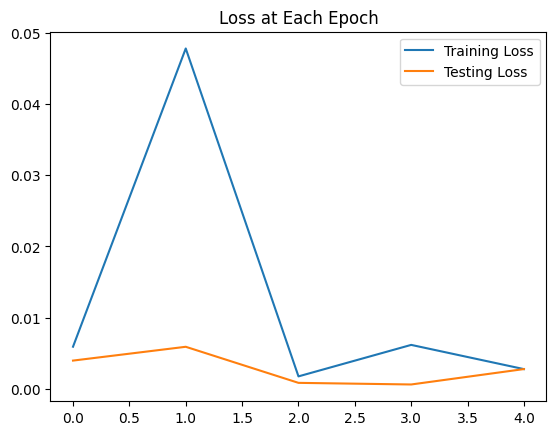

In [66]:
# Graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Each Epoch')
plt.legend()

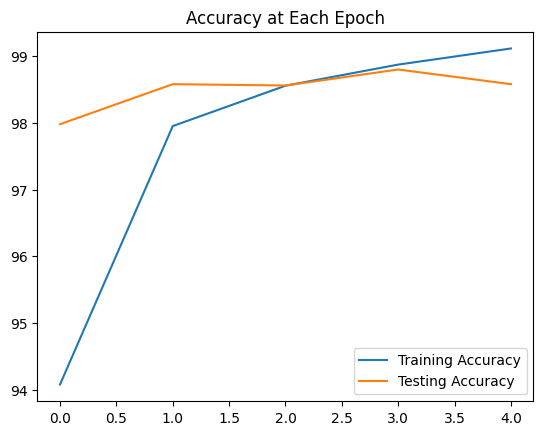

In [72]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at Each Epoch')
plt.legend()

In [73]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle=False)

In [74]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct/10000}')

Test Accuracy: 0.98580002784729


In [75]:
correct.item()

9858

In [76]:
correct.item()/len(test_data)*100

98.58

In [77]:
# Grab an Image
test_data[4143] # Tensor with an image in it...at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [78]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [79]:
# Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

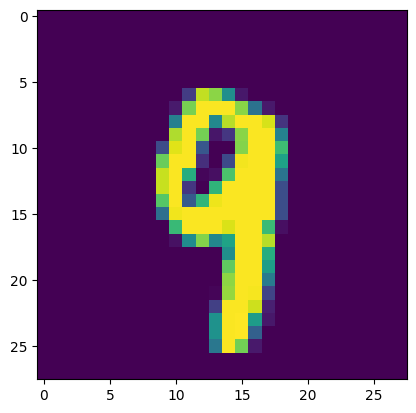

In [80]:
# Show the Image
plt.imshow(test_data[4143][0].reshape(28,28))



In [81]:
# Pass the image through our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) # Batch size of 1, 1 color channel, 28 x 28 image

In [82]:
# Check the new prediction...get probabilties
new_prediction


tensor([[-1.9771e+01, -2.0013e+01, -2.2952e+01, -1.6348e+01, -1.4584e+01,
         -1.8144e+01, -2.3090e+01, -1.8283e+01, -1.5890e+01, -7.1526e-07]])

In [84]:
new_prediction.argmax()

tensor(9)